# 📊 Stock Market Prediction Using Random Forests
---
## ⚠️ Disclaimer
> **The predictions and signals generated by this notebook are for educational and research purposes only. They should not be considered financial advice or used as the sole basis for investment decisions.**
- **No Guarantees:** The model provides probabilistic forecasts, not guarantees. Past performance is not indicative of future results.
- **High Risk:** Stock markets are volatile. Always consult a licensed financial advisor before making investment decisions.
- **No Liability:** The creator(s) of this notebook are not responsible for any financial losses incurred from using these predictions.
- **User Responsibility:** You assume all risks associated with the use of this tool. Investments may lose value.

By using this notebook, you acknowledge that you have read this disclaimer and agree to use it at your own risk.
---
## Overview
This notebook demonstrates how to use Random Forests for predicting buy/sell signals in the stock market using historical price data and engineered features. It covers data download, feature engineering, model training, evaluation, and visualization.

In [1]:
# Install matplotlib for plotting (run only if not already installed)
!pip install matplotlib

## 📦 Install Required Libraries
This cell ensures that `matplotlib` is installed for data visualization. If running in a local environment, make sure all required packages are installed:
- pandas
- numpy
- matplotlib
- yfinance
- scikit-learn
- seaborn

In [2]:
# Import essential libraries for data analysis, visualization, and machine learning
import pandas as pd           # Data manipulation and analysis
import numpy as np            # Numerical operations
import matplotlib.pyplot as plt # Data visualization
import yfinance as yf         # Download historical stock data from Yahoo Finance
from sklearn.model_selection import train_test_split # Split data into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # Random Forest model for classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Model evaluation metrics
import seaborn as sns         # Advanced data visualization

## 📚 Import Libraries
This cell imports all necessary libraries for data handling, visualization, feature engineering, and machine learning.

In [3]:
# Download historical stock data for Sasol Ltd (SOL.JO) from Yahoo Finance
# You can change the ticker symbol, start date, and end date as needed
data = yf.download("SOL.JO", start="2024-01-01", end="2025-06-20")

C:\Users\ethan\AppData\Local\Temp\ipykernel_27368\2538816998.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SOL.JO", start="2024-01-01", end="2025-06-20")
[*********************100%***********************]  1 of 1 completed


## 📥 Download Historical Stock Data
This cell downloads daily price and volume data for Sasol Ltd (SOL.JO) from Yahoo Finance. You can change the ticker, start date, or end date to analyze other stocks or time periods.

In [4]:
# Print the shape of the data (rows, columns)
print(data.shape)

# Print the first five rows to preview the data
print(data.head())

(365, 5)
Price              Close          High           Low          Open   Volume
Ticker            SOL.JO        SOL.JO        SOL.JO        SOL.JO   SOL.JO
Date                                                                       
2024-01-02  18278.398438  18607.351618  18148.416938  18697.338810  1111939
2024-01-03  18207.408203  18392.381872  17997.438092  18302.394682  1454470
2024-01-04  18397.382812  18704.339145  18207.409838  18207.409838  1209877
2024-01-05  18525.363281  18525.363281  18017.435575  18217.407113  1410368
2024-01-08  17944.447266  18450.375294  17794.468601  18487.370031  2042612


## 🔍 Inspect Downloaded Data
This cell prints the shape and the first few rows of the downloaded data to verify successful loading and understand the dataset structure.

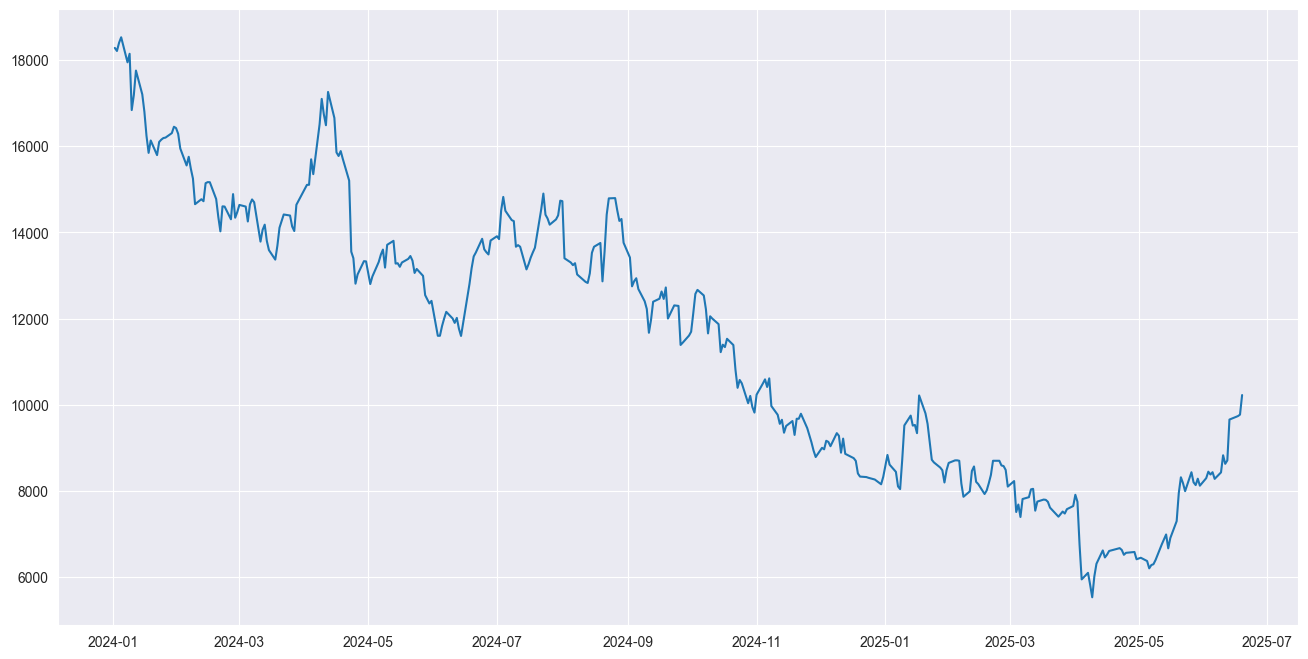

In [5]:
# Plot the closing price history of the stock
plt.figure(figsize=(16,8))  # Set the figure size for the plot
plt.plot(data['Close'], label='Closing Price')  # Plot closing prices with label

## 📈 Visualize Closing Prices
This cell plots the closing price history to help visualize trends, patterns, and volatility in the stock data.

In [6]:
# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(prices, window=14):
    delta = prices.diff()  # Calculate price changes
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average losses
    rs = gain / loss  # Relative strength
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    return rsi

## 📊 Calculate RSI (Relative Strength Index)
This cell defines a function to calculate the RSI, a popular technical indicator used to measure the magnitude of recent price changes and identify overbought or oversold conditions.

Input Features to predict whether a customer should buy or sell the stock

## 🏗️ Feature Engineering
This section creates new features from the raw price and volume data to help the model learn patterns for buy/sell prediction. Features include price changes, moving averages, RSI, and volatility.

In [7]:
# Create new features for buy/sell prediction
data['Open - Close'] = data['Open'] - data['Close']  # Difference between open and close prices
data['High - Low'] = data['High'] - data['Low']      # Difference between high and low prices
data['Price_Change'] = data['Close'].pct_change()    # Daily percentage change in closing price
data['Volume_Change'] = data['Volume'].pct_change()  # Daily percentage change in volume
data['MA_5'] = data['Close'].rolling(window=5).mean()  # 5-day moving average of closing price
data['MA_20'] = data['Close'].rolling(window=20).mean() # 20-day moving average of closing price
data['RSI'] = calculate_rsi(data['Close'], 14)         # 14-day RSI
data['Volatility'] = data['Close'].rolling(window=10).std() # 10-day rolling standard deviation (volatility)

In [8]:
# Remove rows with missing values after feature engineering
data = data.dropna()
print(print(f"\nData shape after feature engineering: {data.shape}"))  # Print new shape of the data


Data shape after feature engineering: (346, 13)
None


## 🧹 Clean Data
After feature engineering, this cell removes rows with missing values to ensure the model trains on complete data only.

In [9]:
# Select engineered features as input variables for the model
X = data[['Open - Close', 'High - Low', 'Price_Change', 'Volume_Change',
          'MA_5', 'MA_20', 'RSI', 'Volatility']]
X.head()  # Display the first few rows of input features

Price,Open - Close,High - Low,Price_Change,Volume_Change,MA_5,MA_20,RSI,Volatility
Ticker,,,,,,,,
Date,,,,,,,,
2024-01-29,-98.985917,447.936269,0.006420,0.119554,16186.696875,17010.379492,32.529914,273.579887
2024-01-30,-171.975538,364.948089,0.009078,-0.198281,16257.286914,16918.942578,45.293141,196.711208
2024-01-31,26.996159,387.944806,-0.001884,0.169712,16311.079297,16829.505371,39.873431,214.362656
2024-02-01,-152.978232,442.936972,-0.008099,-0.256007,16330.676563,16723.920361,28.141765,186.380015
2024-02-02,440.937269,525.925178,-0.020874,0.111041,16280.283789,16594.938770,30.047717,202.603841


## 🎯 Select Input Features
This cell selects the engineered features to be used as input variables for the Random Forest model.

In [10]:
# Create target labels: 1 for 'Buy', -1 for 'Sell'
Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)  # Compare next day's close to today's
Y = Y[:-1]  # Remove last value to align with features
X = X[:-1]  # Remove last row to match target length

## 🏷️ Create Target Labels
This cell creates the target variable for classification:
- 1 for 'Buy' signal (next day's close is higher than today's)
- -1 for 'Sell' signal (next day's close is lower than today's)

In [11]:
# Print the shapes of input features and target labels
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Features shape: (345, 8)
Target shape: (345, 1)


## 📏 Inspect Feature and Target Shapes
This cell prints the shapes of the input features and target labels to confirm correct alignment before model training.

In [12]:
# Split the feature and target data into training and testing sets
from sklearn.model_selection import train_test_split  # Import the function for splitting data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,                # Features and target labels
    test_size=0.2,      # 20% of the data will be used for testing
    random_state=42     # Set random seed for reproducibility
)
print(f"\nTraining set size: {X_train.shape[0]}")  # Print number of training samples
print(f"Test set size: {X_test.shape[0]}")         # Print number of testing samples


Training set size: 276
Test set size: 69


### Why Split Data into Training and Testing Sets?
Splitting your dataset is a fundamental step in machine learning to ensure your model can generalize to new, unseen data.

- **Training Set:** Used to fit the Random Forest model and learn patterns from historical data.
- **Testing Set:** Used to evaluate how well the model performs on data it has never seen before.

**How is the split done?**
- Typically, 80% of the data is used for training and 20% for testing.
- The split is randomized, but setting a `random_state` ensures reproducibility.

This approach helps prevent overfitting and gives a realistic estimate of model performance.

## ✂️ Split Data into Training and Testing Sets
This cell splits the data into training and testing sets to evaluate the model's performance on unseen data. Typically, 80% is used for training and 20% for testing.

In [13]:
from sklearn.model_selection import GridSearchCV

print("\n=== Training Random Forest Classifier ===")
rf_params ={
    'n_estimators':[25, 50, 100, 150, 200, 250, 300],
    'max_depth':[2, 3, 5,10,15,20,25,None],
    'min_samples_split':[2,5,7,10],
    'min_samples_leaf':[1,2,3,4,5],
}
rf = RandomForestClassifier(random_state=42)
rf_model = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy',n_jobs=-1,verbose=1)
rf_model.fit(X_train, Y_train)

print(f"Best parameters: {rf_model.best_params_}")
print(f"Best score: {rf_model.best_score_:.3f}")


=== Training Random Forest Classifier ===
Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}
Best score: 0.594


C:\Users\ethan\PycharmProjects\Stock Price Prediction\.venv\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [14]:
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)


In [15]:
# Calculate accuracies
train_accuracy = accuracy_score(Y_train, train_predictions)
test_accuracy = accuracy_score(Y_test, test_predictions)

In [16]:
print(f"\nTraining accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Overfitting check: {train_accuracy - test_accuracy:.3f}")


Training accuracy: 0.844
Test accuracy: 0.551
Overfitting check: 0.293


In [17]:
# Detailed classification report
print("\n=== Classification Report ===")
print(classification_report(Y_test, test_predictions, target_names=['Sell (-1)', 'Buy (1)']))


=== Classification Report ===
              precision    recall  f1-score   support

   Sell (-1)       0.62      0.57      0.60        40
     Buy (1)       0.47      0.52      0.49        29

    accuracy                           0.55        69
   macro avg       0.55      0.55      0.54        69
weighted avg       0.56      0.55      0.55        69



## 📋 Classification Report
This cell prints a detailed classification report for the test set predictions.

- The report includes precision, recall, f1-score, and support for each class (Buy/Sell).
- These metrics help you understand the quality of the model's predictions beyond simple accuracy.

Use this to evaluate how well your model is distinguishing between buy and sell signals and to identify areas for improvement.


=== Confusion Matrix ===


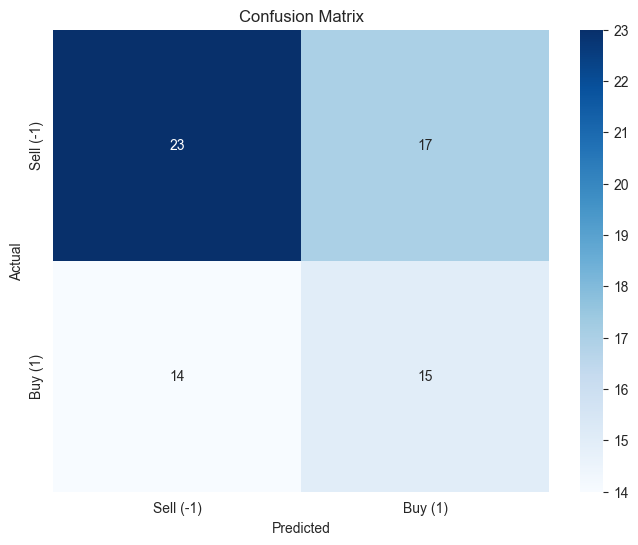

In [18]:
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(Y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sell (-1)', 'Buy (1)'],
            yticklabels=['Sell (-1)', 'Buy (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 🟦 Confusion Matrix
This cell visualizes the confusion matrix for the test set predictions.

- The confusion matrix shows the number of correct and incorrect predictions for each class (Buy/Sell).
- The heatmap makes it easy to see where the model is making mistakes.

Use this to understand the types of errors your model is making and whether it is biased toward one class.


=== Feature Importance ===
             Feature  Importance
7     (Volatility, )    0.154462
4           (MA_5, )    0.143407
6            (RSI, )    0.137200
2   (Price_Change, )    0.137138
3  (Volume_Change, )    0.125655
5          (MA_20, )    0.119891
0   (Open - Close, )    0.093201
1     (High - Low, )    0.089046


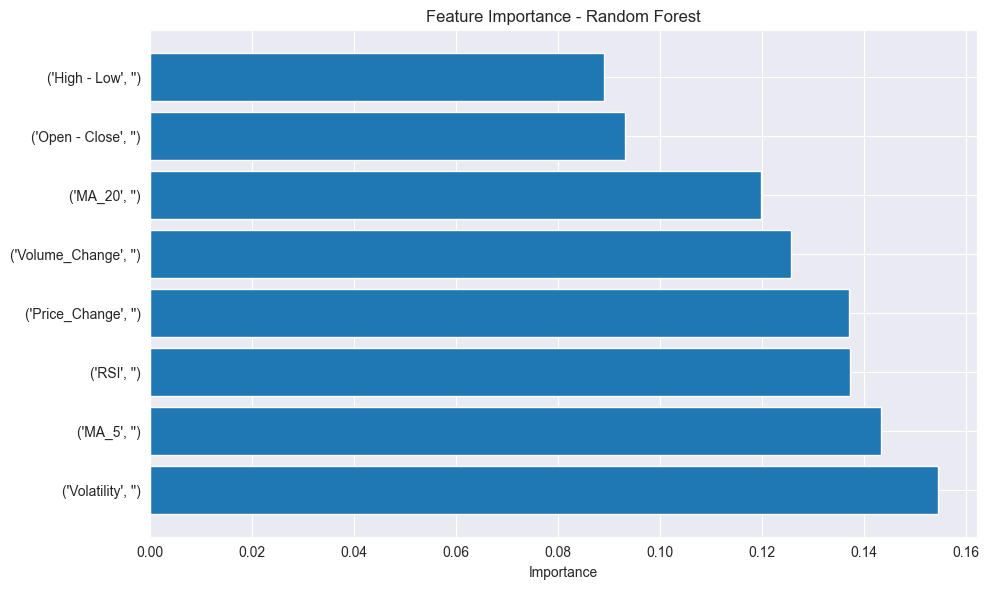

In [19]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'].values)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'].values)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 🌟 Feature Importance
This cell displays the importance of each input feature as determined by the trained Random Forest model. Higher importance means the feature contributed more to the model's decision-making.

- The table shows the relative importance of each feature.
- The bar plot visualizes which features are most influential for predicting buy/sell signals.

Use this information to understand which factors drive the model's predictions and to potentially refine your feature set.

In [20]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': Y_test.ravel(),
    'Predicted': test_predictions.ravel(),
    'Correct': Y_test.ravel() == test_predictions.ravel()
})

## 🔎 Prediction Sample
This cell shows a sample of the model's predictions compared to the actual buy/sell signals from the test set.

- The table displays the actual signal, predicted signal, and whether the prediction was correct.
- The accuracy and the number of buy/sell signals are also calculated.

This helps you quickly assess how well the model is performing on individual samples and overall.


=== Prediction Sample ===
   Actual  Predicted  Correct
0       1         -1    False
1       1          1     True
2      -1         -1     True
3      -1         -1     True
4       1          1     True
5       1         -1    False
6      -1          1    False
7      -1         -1     True
8       1          1     True
9      -1         -1     True

Prediction accuracy: 55.1%
Buy signals: 32
Sell signals: 37


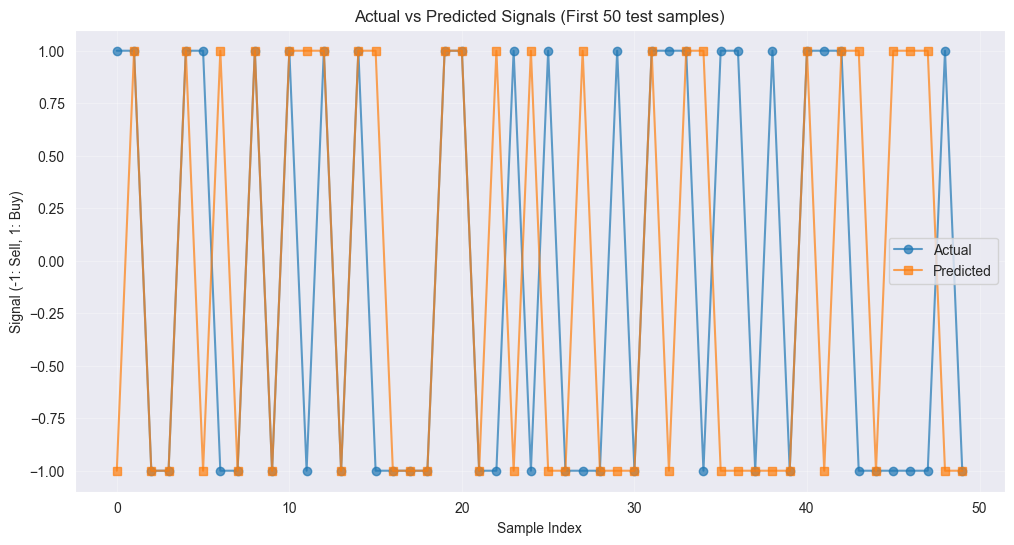

In [21]:
print("\n=== Prediction Sample ===")
print(comparison_df.head(10))

# Calculate daily returns if we followed the model
print(f"\nPrediction accuracy: {(comparison_df['Correct'].sum() / len(comparison_df)) * 100:.1f}%")
print(f"Buy signals: {(test_predictions == 1).sum()}")
print(f"Sell signals: {(test_predictions == -1).sum()}")

# Plot actual vs predicted over time (sample)
plt.figure(figsize=(12, 6))
sample_size = min(50, len(Y_test))
x_range = range(sample_size)
plt.plot(x_range, Y_test[:sample_size], 'o-', label='Actual', alpha=0.7)
plt.plot(x_range, test_predictions[:sample_size], 's-', label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Signals (First 50 test samples)')
plt.xlabel('Sample Index')
plt.ylabel('Signal (-1: Sell, 1: Buy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()